<img src="logos.jpg" width="700" />

# Tensorflow example using Mnist dataset

The purpose of this notebook is to ilustrate the use of __Tensorflow__ package in an example that includes the construction of a neural network and the use of a supervised learning approach based in the back-propagation theory. The proposed example is based on the classic Mnist dataset in which the main objective is to identify images of hand-written digits.

Example main features:

1. All the code was implemented in Python 3.5 https://www.python.org/ 
2. The  Python packages required to run the programs are the following:
    * Jupyter notebook (Python interactive prompt) http://jupyter.org/index.html
    * Tensorflow (Representation-classification) https://www.tensorflow.org/
    * Numpy (classification) http://www.numpy.org/
    * Matplotlib (visualization) https://matplotlib.org/
3. The Tensorflow version used correspond to a standalone application which means that does not support the use of parallel 
   computations on GPUs.

    
## Step 1: Load the MNIST dataset

The Mnist dataset includes over 60,000 training images, plus 10,000 test images resized into 28x28 matices with grayscale values between 0 and 254.The following shows how to load this dataset:

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


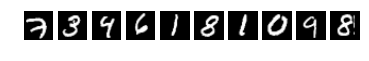

Labels: 7 , 3 , 4 , 6 , 1 , 8 , 1 , 0 , 9 , 8


In [2]:
#Command used to see the plot inside the Jupyter notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#Package used to get the Mnist dataset from Tensorflow available examples
from tensorflow.examples.tutorials.mnist import input_data
#Load the Mnist dataset
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
labels=[]
#Plot the first ten images of the Mnist dataset
for number in range(10):
    #Add a subplot to the matplotlib main canvas
    plt.subplot(1,10,number+1)
    #Get images and labels from the dataset
    image=mnist.train.images[number]
    label=mnist.train.labels[number]
    #Transform the image to a numpy object to manipulate it
    image=np.array(image, dtype='float')
    #Reshape(rows,columns) the digits from a matrix of (784,) to a matrix of (28,28)
    plt.imshow(image.reshape(28, 28), cmap='Greys_r')
    #Eliminate axis labels from the plot
    plt.axis('off')
    labels.append(label)
#Show the plot (ten images)    
plt.show()
#Transform the labels to a single number instead of a list
labels=[str([i for i,y in enumerate(x) if y == 1][0]) for x in labels]
print ("Labels: "+" , ".join(labels))

## Step 2: Preprocess the Mnist dataset
1. Cast the digits from each training image to a float number (in case of any error in the dataset)

In [3]:
#Empty lists for storing reshaped images and labels
trainingImages= []
trainingLabels=[]
#For each image
for image in mnist.train.images:
    #Transform all the values to a float data type
    image=np.array(image, dtype='float')
    #Transform an image to a matrix of 28x28
    trainingImages.append(image)
#Obtain the labels associated to each image (in a scalar form instead of a vector)
for label in mnist.train.labels:   
    trainingLabels.append(str([i for i,y in enumerate(label) if y == 1][0]))
#Transform the training list to a numpy array (for compatibility with Tensorflow function)   
trainingImages = np.array(trainingImages, np.float32)    
trainingLabels = np.array(trainingLabels, np.int32) 
print ("Reshaped image examples")
print(trainingImages[:10])
print ("Reshaped label examples")
print(trainingLabels[:10])
print ("Images dimensions: " + str(trainingImages.shape))
print ("Labels dimensions: " + str(trainingImages.shape))



Reshaped image examples
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Reshaped label examples
[7 3 4 6 1 8 1 0 9 8]
Images dimensions: (55000, 784)
Labels dimensions: (55000, 784)


2\. Reshape the digits from each test image to a matrix of (28,28) (rows,columns)

In [4]:
testImages= []
testLabels=[]
for image in mnist.test.images:
    image=np.array(image, dtype='float')
    testImages.append(image)   
for label in mnist.test.labels:   
    testLabels.append(str([i for i,y in enumerate(label) if y == 1][0]))  
testImages = np.array(testImages, np.float32)    
testLabels = np.array(testLabels, np.int32) 

## Step 3: Define the Tensorflow graph 

1. Remainder of the Back-propagtion intuition

<img src="backPropagation.jpg" alt="Drawing" style="width: 600px;"/>


2\.  Multi-layer perceptron proposed for this example

<img src="backPropagation2.png" alt="Drawing" style="width: 600px;"/>


3\.  Create the proposed graph in the Tensorflow environment considering that nodes in the graph represent mathematical operations, whereas edges represent data (tensors) that is communicated from one node to others. It is important to highlight that tensors are multidimensional arrays (representing vectors with a 1D tensors, matrices with a 2D tensors, etc.).

In [5]:
import tensorflow as tf

#Number of neurons for the input layer
n_inputs = 28*28 #Features size
#Number of neurons per hidden layer
n_hidden1 = 300
n_hidden2 = 300
n_hidden3 = 100
#Number of neurons for the output layer
n_outputs = 10

Inside the graph construction, a placeholder is simply a variable that we will assign data to at a later date. It allows us to create our operations and build our computation graph, without needing the data.

In [6]:
#https://www.tensorflow.org/api_docs/python/tf/placeholder
#Training sample representation
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")  #2D tensor
#Target sample representation
y = tf.placeholder(tf.int32, shape=(None), name="y") #1D tensor

After define the placeholders, we can create a function that represents the behavior of a neural network layer. It is important to noticed that in the function there are define multiple Tensorflow variables which helps to represent shared, persistent values across a graph execution. 

In [7]:
"""
Function parameters:

X = Vector features (28x28)
n_neurons = Number of neurons for a layer
name= Layer name
activation = Activation functions used for each neuron
"""
def neuron_layer(X, n_neurons, name, activation=None):
    #Tensorflow name scope to group together operations (nodes) in the graph
    with tf.name_scope(name):
        #Get the number of elements by checking the vectors feature shape
        n_inputs = int(X.get_shape()[1])
        #Create a random weight matrix using a Gaussian distribution
        #The standard deviation helps the algorithm to converge faster in a training phase
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="weights")
        #Create a Tensorflow variable for the bias
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        """
        ATTENTION: Creation of the graph in Tensorflow
        Compute the weighted sum of the inputs plus the bias term for each neuron the layer
        https://www.tensorflow.org/api_docs/python/tf/matmul
        """
        Z = tf.matmul(X, W) + b
        #Returns the activation function of each neuron in the layer
        if activation is not None:
            return activation(Z)
        else:
            return Z

Finally, the different layers are created in the graph (neural network) using the previously created function.

In [8]:
#Tensorflow name scope to group together operations (nodes) in the graph
with tf.name_scope("dnn"):
    # The first layer take the feature vector as input
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",activation=tf.nn.relu)
    #The second layer take the output of the first layer as input
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",activation=tf.nn.relu)
    #The third layer take the output of the second layer as input
    hidden3 = neuron_layer(hidden2, n_hidden3, name="hidden3",activation=tf.nn.relu)
    #The output of the third layer is taken as input for the final layer
    #Outputs are also called logits in the neural network theory
    ouputs = neuron_layer(hidden3, n_outputs, name="outputs")

The activation function use in the neural network is presented below (https://www.tensorflow.org/versions/r1.0/api_guides/python/nn):

<img src="ReLU.png" alt="Drawing" style="width: 500px;"/>

## Step 4: Create a cost function and optimizer for the Tensorflow graph

1. Define a cost function that helps to obtain the error rate between the neural network output and the real value provided by the training labels. In this case the __softmax cross entropy__ is used, considering that this function penalize models that estimate a low probability for the target labels. The softmax cross entropy function first apply the softmax activation and then compute the cross entropy. In order to obtain the error rate (single value) associated, the __mean cross entropy__ is obtained.

<img src="cost.png" alt="Drawing" style="width: 400px;"/>
<img src="softmaxFun.jpg" alt="Drawing" style="width: 400px;"/>
<img src="crossEntropy.png" alt="Drawing" style="width: 400px;"/>

In [9]:
with tf.name_scope("cost"):
    #https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits
    #Obtain the softmax cross entropy which returns a ID tensor
    entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=ouputs)
    #Obtain the mean value associated to the 1D tensor previously calculated
    #https://www.tensorflow.org/api_docs/python/tf/reduce_mean
    loss = tf.reduce_mean(entropy, name="loss")

2\. After obtaining the error rate associated to the graph we need to minimize the cost function by updating the graph weights using an optimization process. In this case it is use a gradient descent approach considering its versatility to be applied to different types of problems.

<img src="gradient.png" alt="Drawing" style="width: 400px;"/>

In [10]:
"""
the Learning step is a hyper-parameter that controls how much we are adjusting the weights of our network with respect the 
loss gradient. The lower the value, the slower we travel along the downward slope
"""
learningStep = 0.01
#Tensorflow name scope to group together operations (nodes) in the graph
with tf.name_scope("train"):
    #Prepare the optimizer
    #https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer
    optimizer = tf.train.GradientDescentOptimizer(learningStep)
    #Minimize the error rate
    training_op = optimizer.minimize(loss)


## Step 5: training phase

1. Specify how to evaluate  the model that is going to be created from the neural network. First, for each instance, determine if the neural networks prediction is correct by checking whether or not the highest value obtained in the output layer correspond to the target label. Later calculate the average of the results obtained and calculate the accuracy.

In [11]:
with tf.name_scope("evaluation"):
    #https://www.tensorflow.org/api_docs/python/tf/nn/in_top_k
    #Says whether the targets are in the top K predictions.
    correct = tf.nn.in_top_k(ouputs, y, 1)
    #Obtain the accuracy for each training vector
    #https://www.tensorflow.org/api_docs/python/tf/cast
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

2\. Implement a function that divides the training dataset into a number of sets or parts for creating the neural network easily.

In [12]:
def createBatch(X, y, batch_size):
    #Obtan a list of random indices from 0 to len(X)
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    #Split a list into multiple sub-arrays.
    for batch_idx in np.array_split(rnd_idx, n_batches):
        #Obtain the list batches
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        #Return a Python generator that creates the batches on the fly without saving them in memory
        yield X_batch, y_batch

3\. After the construction of the graph structure and the operations associated, the next step is to create a classification model following a supervised learning approach.

In [13]:
#Allocate all the variables in the Tensorflow environment for initialization
#https://www.tensorflow.org/api_docs/python/tf/global_variables
init = tf.global_variables_initializer()
#Tensorflow variable used for saving (and restoring) our model to disk
#https://www.tensorflow.org/api_docs/python/tf/train/Saver
saver = tf.train.Saver()
#Number of epochs that we want to run the model
numberEpochs = 15
#Number of batches related to each epoch
batchSize = 50
"""
Create a TensorFlow session to run the graph across a set of local and remote devices. A Session object 
encapsulates the environment in which Operation objects are executed, and tensor objects are evaluated.
"""
with tf.Session() as sess:
    #Initialize all variables in the session
    init.run()
    #One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.
    for epoch in range(numberEpochs):
        #Since, one epoch is too big to feed to the computer at once we divide it in several smaller batches.
        for X_batch, y_batch in createBatch(trainingImages, trainingLabels, batchSize):
            #Train the neural network using each batch 
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        #Evaluate the accuracy for each batch    
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})   
        print("Epoch:",epoch+1, "Batch accuracy:", acc_batch)
    #Save the model in the disk for evaluation later the test dataset  
    save_path = saver.save(sess, "./NeuralNetworkModel.ckpt")      

Epoch: 1 Batch accuracy: 0.92
Epoch: 2 Batch accuracy: 1.0
Epoch: 3 Batch accuracy: 0.96
Epoch: 4 Batch accuracy: 0.92
Epoch: 5 Batch accuracy: 0.98
Epoch: 6 Batch accuracy: 0.98
Epoch: 7 Batch accuracy: 1.0
Epoch: 8 Batch accuracy: 1.0
Epoch: 9 Batch accuracy: 1.0
Epoch: 10 Batch accuracy: 0.96
Epoch: 11 Batch accuracy: 0.98
Epoch: 12 Batch accuracy: 0.98
Epoch: 13 Batch accuracy: 0.98
Epoch: 14 Batch accuracy: 1.0
Epoch: 15 Batch accuracy: 1.0


## Step 6: test phase

- Evaluate the proposed model in the Mnist test dataset

In [14]:
"""
Create a TensorFlow session to run the graph across a set of local and remote devices. A Session object 
encapsulates the environment in which Operation objects are executed, and tensor objects are evaluated.
"""
with tf.Session() as sess:
    #Recover the model from the disk
    saver.restore(sess, "./NeuralNetworkModel.ckpt")
    #Obtain the first twenty images from the test dataset
    testSubset = testImages[:20]
    #Apply the model for each image to obtain a prediction (number label)
    Z = ouputs.eval(feed_dict={X:testSubset})
    #Obtain the index of the maximum value of the ten neurons in the ouput layer
    predictions = np.argmax(Z, axis=1)
    #Show a comparison of predicted values and true values (gold standard)
    print("Predicted classes:", predictions)
    print("Actual classes:   ", testLabels[:20])  
    accuracyPrediction = accuracy.eval(feed_dict={X: X_batch, y: y_batch})   
    print("Accuracy prediction:", accuracyPrediction)

INFO:tensorflow:Restoring parameters from ./NeuralNetworkModel.ckpt
Predicted classes: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
Accuracy prediction: 1.0


## Conlusions

- What we seen so far:
    1. Load and inspect an specific dataset.
    2. Preprocess the information associated to the dataset.
    3. Creation of a Neural network using the Tensorflow package.
        * Input layer with seven hundred and eighty four neurons.
        * Two hiden layers of three hundred neurons.
        * One layer of one hundred neurons.
        * One ouput layer of ten neurons, one for each posible number in the dataset (0, 1, ..., 9).
    4. Implementation of a cost function and an optimizer for training the neural network.
    5. Creation of a model using the training dataset provided.
    6. Evaluation of the test dataset set using the model created.
- Obtained results highlight the following findings:  
    1. Tensorflow permits to create a graph where nodes are operations and edges are information that flows from one operation to others.
    2. The variables, constants and placeholders created in Tensorflow not need to be evaluated immediately or in the same machine.
    3. There are multiple predefined functions in Tensorflow that can help to create a neural network easily.
    4. If the computations were dense, we can distribute the job processing among different computers or gpus using Tensorflow API.